# Image Deblurring - June Exam - Tony Chahoud 

### Dataset creation - DO NOT MODIFY

In [1]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

Downloading DATA 



In [2]:
(blurred_train, original_train), (blurred_test, original_test) = getDataset()

170508288/170498071 [==============================] - 3s 0us/step


SHape of the Train and Test data :


In [3]:
print("Train Data shape:", blurred_train.shape)
print("Test Data shape:", blurred_test.shape)


Train Data shape: (50000, 32, 32, 3)
Test Data shape: (10000, 32, 32, 3)


As our  database is a large database of Blurred RGB Colored Photos;  where the train Data have 50,000 records and the test dataset has 10,000 records. Each record has hieght=32 x width=32 x 3(3 channels=RGB),So  it means we have 1024 pixels in the data and every pixel has an R-G-B value hence 3 color channels.

 So we choose a **Convolutional Autoencoder** Model to be trained in order to deblur images , as this Model  retain the spatial and the temporal  information of the images . 



In [4]:
#GEtting The shape of our Images(training or/Test),as  Each of the 32x32x3 values is a node in the input layer. 

_,h,w,c = blurred_train.shape

so, our Model should be trained in order to copy its input to output, by reducing error(MSE) and avoiding Overfitting , and that what the AutoEncoder can do, to end up with deblurred Images . and the 2 mains steps beside this model are :      
1-***Encoder***: to  downsamples the data into lower dimensions.

2-**Decoder**: to reconstructs the original data from the lower dimension representation.


In [5]:
from tensorflow import keras
from keras import layers, Model
#
#defining the input layer of our Modle 

input = layers.Input(shape=(h,w,c))

# **Network Architecture **

Encoder part  reduce size of the image and the decoder part will increase it back . So  decoder makes reverses operations compare to the encoder.. 

In [6]:

# Encoder

#CNN learns the weights of these Kernels on its own. 
#Conv2D =is a feature map to detect features rather than looking into every single pixel value.

#the 32X32 in 3 Cahnnels Input , are concoluted by 64 Learned filters in the first layer of the Encoder
#out-Channels Become 64  
x1=layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)

#Pooling layer decreases the sizes of the RGB image by using a Max pooling function
#it summarize the presence of features in patches of the feature map
U1 = layers.MaxPooling2D((2, 2), padding="same")(x1)

# decreasing our out_channels to 32.

x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(U1)
#The Second Doun Sampling layer ( 2nd Max pooling )
H = layers.MaxPooling2D((2, 2), padding="same")(x2)


Decoder is also a sequential model. It accepts the encoding and tries to reconstruct it . Then, it stacks it into a 32x32x3 matrix through the Dense layer. The final Reshape layer will reshape it into an image.

In [7]:
# Deocder

#keep on increasing the dimensionality from 32 till we get 64 out_channels by the last convolution layer

#Conv2DTranspose have an opposite role of the pooling function

x3 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(H)

x4 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x3)

#As the outout is not [0 1] as it is RGB and not gray , "tanh" Instead of sigmoid
#As tanh activation function leads to strong gradients and big learning steps, .

r = layers.Conv2D(3, (3, 3), activation="tanh", padding="same")(x4)


# Finally, we end by  3 output-channel in order to reconstruct the original image.




we'll combine both layers into the final **AUTOENCODER** model


In [30]:
#Now we need to compile our MOdel .by Providing :an Adam optimizer and Mean Squared Error .

autoencoder = Model(input, r)
#  'adam'  as defalult is [adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)]

# Mean-Squared-Error used to calculate the dissimilarity between the original pixel(values) and the one predicted by the network

autoencoder.compile(optimizer="adam", loss="mse",metrics="accuracy")

#Saving the weights of the Model 
autoencoder.save_weights
autoencoder.save

print ("our network architecture")

autoencoder.summary()

our network architecture
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (Non


We have total control over the architecture of the autoencoder. The Model can be made very powerful by increasing the number of layers, nodes per layer wich need to high parameters . 

I end Up with this Autoencoder where the image is reconstructed on the same Size as the input ,where the Autoencoder Model weights are derived over :
-  2 Convolution layer + 2 Max Pooling at Encoder 
-  2 Convolutional layers(Up sampling Effect)  at the Decoder

Our Model can be summarized by the following 

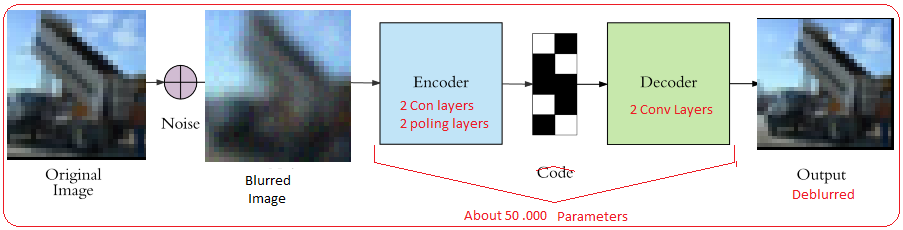

**Model Discussion:**
 
Increasing these hyperparameters will let the autoencoder to learn more complex codings. But we should be careful to not make it too powerful. Otherwise the autoencoder will simply learn to copy its inputs to the output by overfitting without being able to generalize to new instances, which is not what we want.

and in our Model, overfiting didnt take place , even with high numbers of epochs where an improving according the validation loss took place .... By the N"50 Epochs ,we reach a minimal MSE (about 0.0037) 


**Why this Model ?**

I trained the same autoencoder model but with more Paramters ( about 120.000) where an additional conv-layer(32) is added to the encoder(3 layers in Total per emcoder) and another one(32) to the Decoder(3 layers in Total per Decoder) , Same improvement , No Overfitiing , but the MSE reduction was too slow and by the 50 epchs was Above 0.004.

The good part is that Overfitting was also avoided , by Training A COmplex Autoencoder(about 8 Downsampling Convolutional layers and 8 Upsampling ones)  with the same previous Concept but with huge number of parameter 500K to 600K,good Accuracy was achieved but the Ideal MSE wasn't achieved even for more than 100 epochs...


That why I end Up with this simplest AutoEncodrer Model .
 

In [9]:
#Validation of the Test-Data through the Trained Model 
Hist=autoencoder.fit(
    blurred_train, original_train,
    epochs=10,
    batch_size=128,
    shuffle=True, 
    validation_data=(blurred_test, original_test)
)

Epoch 1/10
391/391 [==============================] - 19s 19ms/step - loss: 0.0204 - accuracy: 0.5396 - val_loss: 0.0075 - val_accuracy: 0.6760
Epoch 2/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0065 - accuracy: 0.7545 - val_loss: 0.0058 - val_accuracy: 0.7950
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.0056 - accuracy: 0.7963 - val_loss: 0.0054 - val_accuracy: 0.8026
Epoch 4/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0053 - accuracy: 0.8041 - val_loss: 0.0052 - val_accuracy: 0.8016
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0051 - accuracy: 0.8081 - val_loss: 0.0050 - val_accuracy: 0.8120
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0050 - accuracy: 0.8112 - val_loss: 0.0049 - val_accuracy: 0.8058
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 0.0049 - accuracy: 0.8137 - val_loss: 0.0048 - val_accuracy: 0.820


So , As we see dring the First 10 Epochs , there is a clear improvement in The MSE

after that , **The training took MORE TIME** with a slight improvemnt concerning the error .



In [11]:
Hist=autoencoder.fit(
    blurred_train, original_train,
    epochs=62,
    batch_size=128,
    shuffle=True,
    validation_data=(blurred_test, original_test)
)

Epoch 1/62
391/391 [==============================] - 7s 18ms/step - loss: 0.0043 - accuracy: 0.8230 - val_loss: 0.0042 - val_accuracy: 0.8133
Epoch 2/62
391/391 [==============================] - 7s 17ms/step - loss: 0.0042 - accuracy: 0.8226 - val_loss: 0.0042 - val_accuracy: 0.8201
Epoch 3/62
391/391 [==============================] - 7s 17ms/step - loss: 0.0042 - accuracy: 0.8237 - val_loss: 0.0042 - val_accuracy: 0.8201
Epoch 4/62
391/391 [==============================] - 7s 17ms/step - loss: 0.0042 - accuracy: 0.8234 - val_loss: 0.0043 - val_accuracy: 0.8126
Epoch 5/62
391/391 [==============================] - 7s 17ms/step - loss: 0.0042 - accuracy: 0.8236 - val_loss: 0.0041 - val_accuracy: 0.8285
Epoch 6/62
391/391 [==============================] - 7s 18ms/step - loss: 0.0041 - accuracy: 0.8239 - val_loss: 0.0041 - val_accuracy: 0.8171
Epoch 7/62
391/391 [==============================] - 7s 18ms/step - loss: 0.0041 - accuracy: 0.8241 - val_loss: 0.0041 - val_accuracy: 0.8331

0.0037 MSE the best achieved by this model after the 70s Epochs (10 was trained firstly ,and the others 62 Above ,to be 
in total  72 )..

same for Accuracy , where an improvement is showed throughout the  Epocs 

In [12]:
import matplotlib.pyplot as plt

In [13]:
print(Hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [14]:
def plot_History(autoencoder_History,Keys): 
 n,val_n= Keys 
 #fig, ax = plt.subplots( figsize=(10,10))
 plt.plot(autoencoder_History.history[n]) 
 plt.plot(autoencoder_History.history[val_n]) 

 plt.ylabel(n)
 plt.xlabel('epoch')
 plt.legend(['train Data', 'test Data'], loc='upper left') 
 
 plt.show()

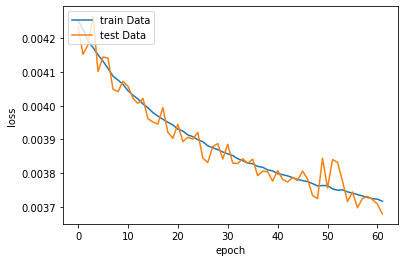

In [31]:

plot_History(Hist,['loss','val_loss'])

                     NO OVERFITTING


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


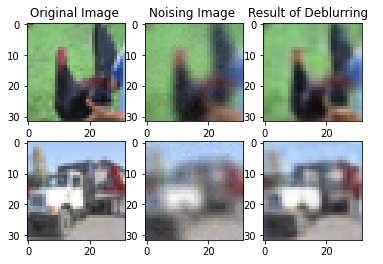

In [32]:
#from matplotlib import pyplot as plt

predictions = autoencoder.predict(blurred_test)
plt.subplot(2,3,1)
plt.title("Original Image ")
plt.imshow(original_test[25])
plt.subplot(2,3,2)
plt.title("Noising Image ")
plt.imshow(blurred_test[25])
plt.subplot(2,3,3)
plt.title("Result of Deblurring  ")
plt.imshow(predictions[25])
plt.subplot(2,3,4)
plt.imshow(original_test[45])
plt.subplot(2,3,5)
plt.imshow(blurred_test[45])
plt.subplot(2,3,6)
plt.imshow(predictions[45])
plt.show()




As we can see the autoencoder did  their job  By removing the Blurring from the Noised image. Despite the improvement in image clarity (less image loss), but there isn’t any improve in the image resolution wish already is noised. 


Many other deep Pre-Trained  learning architectures Deblurr the Noised images such that the result is very close to the ground truth images with minimal loss of detail.Most of them are based on the Convolutional  implementation (like :1- the pre-Trained RDENET Autoencoder wish skip Layers .
2-Multi-level Wavelet CNN wish is based on the U.Net architecture ...)